In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from tensorflow.keras import layers, models

styles = ['隸', '楷', '篆', '行', '草']
column_names = ["key", "character", "style", "author", "image"]

dataframe = pd.read_csv("./hanzi/data.csv", header=None, names = column_names)
authors = dataframe["author"].unique()
dataset_size = dataframe.shape[0]
np.random.shuffle(dataframe.values)

In [2]:
dataframe_train = dataframe.iloc[0:140000]
dataframe_validation = dataframe.iloc[140000:150000]
dataframe_validation.reset_index(drop=True, inplace=True)
dataframe_test = dataframe.iloc[150000:]
dataframe_test.reset_index(drop=True, inplace=True)

print(dataframe_train)
print(dataframe_validation)
print(dataframe_test)

       key character style author                             image
0        彳         徵     草    文征明   彳/徵/png/草/文征明-16955-256x256.png
1        糸         縛     行    敬世江   糸/縛/png/行/敬世江-75574-256x256.png
2        欠         款     草    徐伯清  欠/款/png/草/徐伯清-135108-256x256.png
3        馬         騽     楷    褚遂良    馬/騽/png/楷/褚遂良-3258-256x256.png
4        彳         徐     隸    衡方碑    彳/徐/png/隸/衡方碑-8320-256x256.png
...     ..       ...   ...    ...                               ...
139995   鳥         鹃     草     徐渭   鳥/鹃/png/草/徐渭-129621-256x256.png
139996   一         三     草    张瑞图   一/三/png/草/张瑞图-90687-256x256.png
139997   刀         判     草     王蒙    刀/判/png/草/王蒙-58601-256x256.png
139998   木         标     行    董其昌   木/标/png/行/董其昌-13538-256x256.png
139999   言         謹     行     米芾   言/謹/png/行/米芾-123295-256x256.png

[140000 rows x 5 columns]
     key character style author                              image
0      人         仅     行     王铎    人/仅/png/行/王铎-123252-256x256.png
1      亅         事     

In [3]:
from tensorflow.keras.preprocessing import image as krs_image

def custom__batch_generator(dataframe, batch_size, image_size = 128):
    # Create the arguments for image preprocessing
    data_gen_args = dict()

    # Create an empty data generator
    datagen = krs_image.ImageDataGenerator()
    length = len(dataframe)

    i = 0
    while True:
        batch = {'images': [], 'csv': [], 'labels': []}
        for b in range(batch_size):
            if i >= length:
                i = 0
            try:
                # Read image from list and convert to array
                image_path = "./hanzi/" + dataframe["image"][i]
                image = krs_image.load_img(image_path, grayscale=True, target_size=(image_size, image_size))
                image = datagen.apply_transform(image, data_gen_args)
                image = krs_image.img_to_array(image)

                # Read data from csv using the name of current image
                csv_row = dataframe.loc[i, dataframe.columns != 'image']
                label = csv_row['style']
                #csv_features = csv_row.drop(labels='style')

                batch['labels'].append(styles.index(csv_row['style']))
                batch['images'].append(1 - (image / 255))
            
            except Exception as err:
                print(err)

            i += 1

        # Convert labels to categorical values
        # batch['labels'] = np.eye(5)[batch['labels']]
        
        X = np.array(batch['images'])
        Y = np.array(batch['labels'])


        yield X, Y


/Users/max/yunzhang/.venv/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


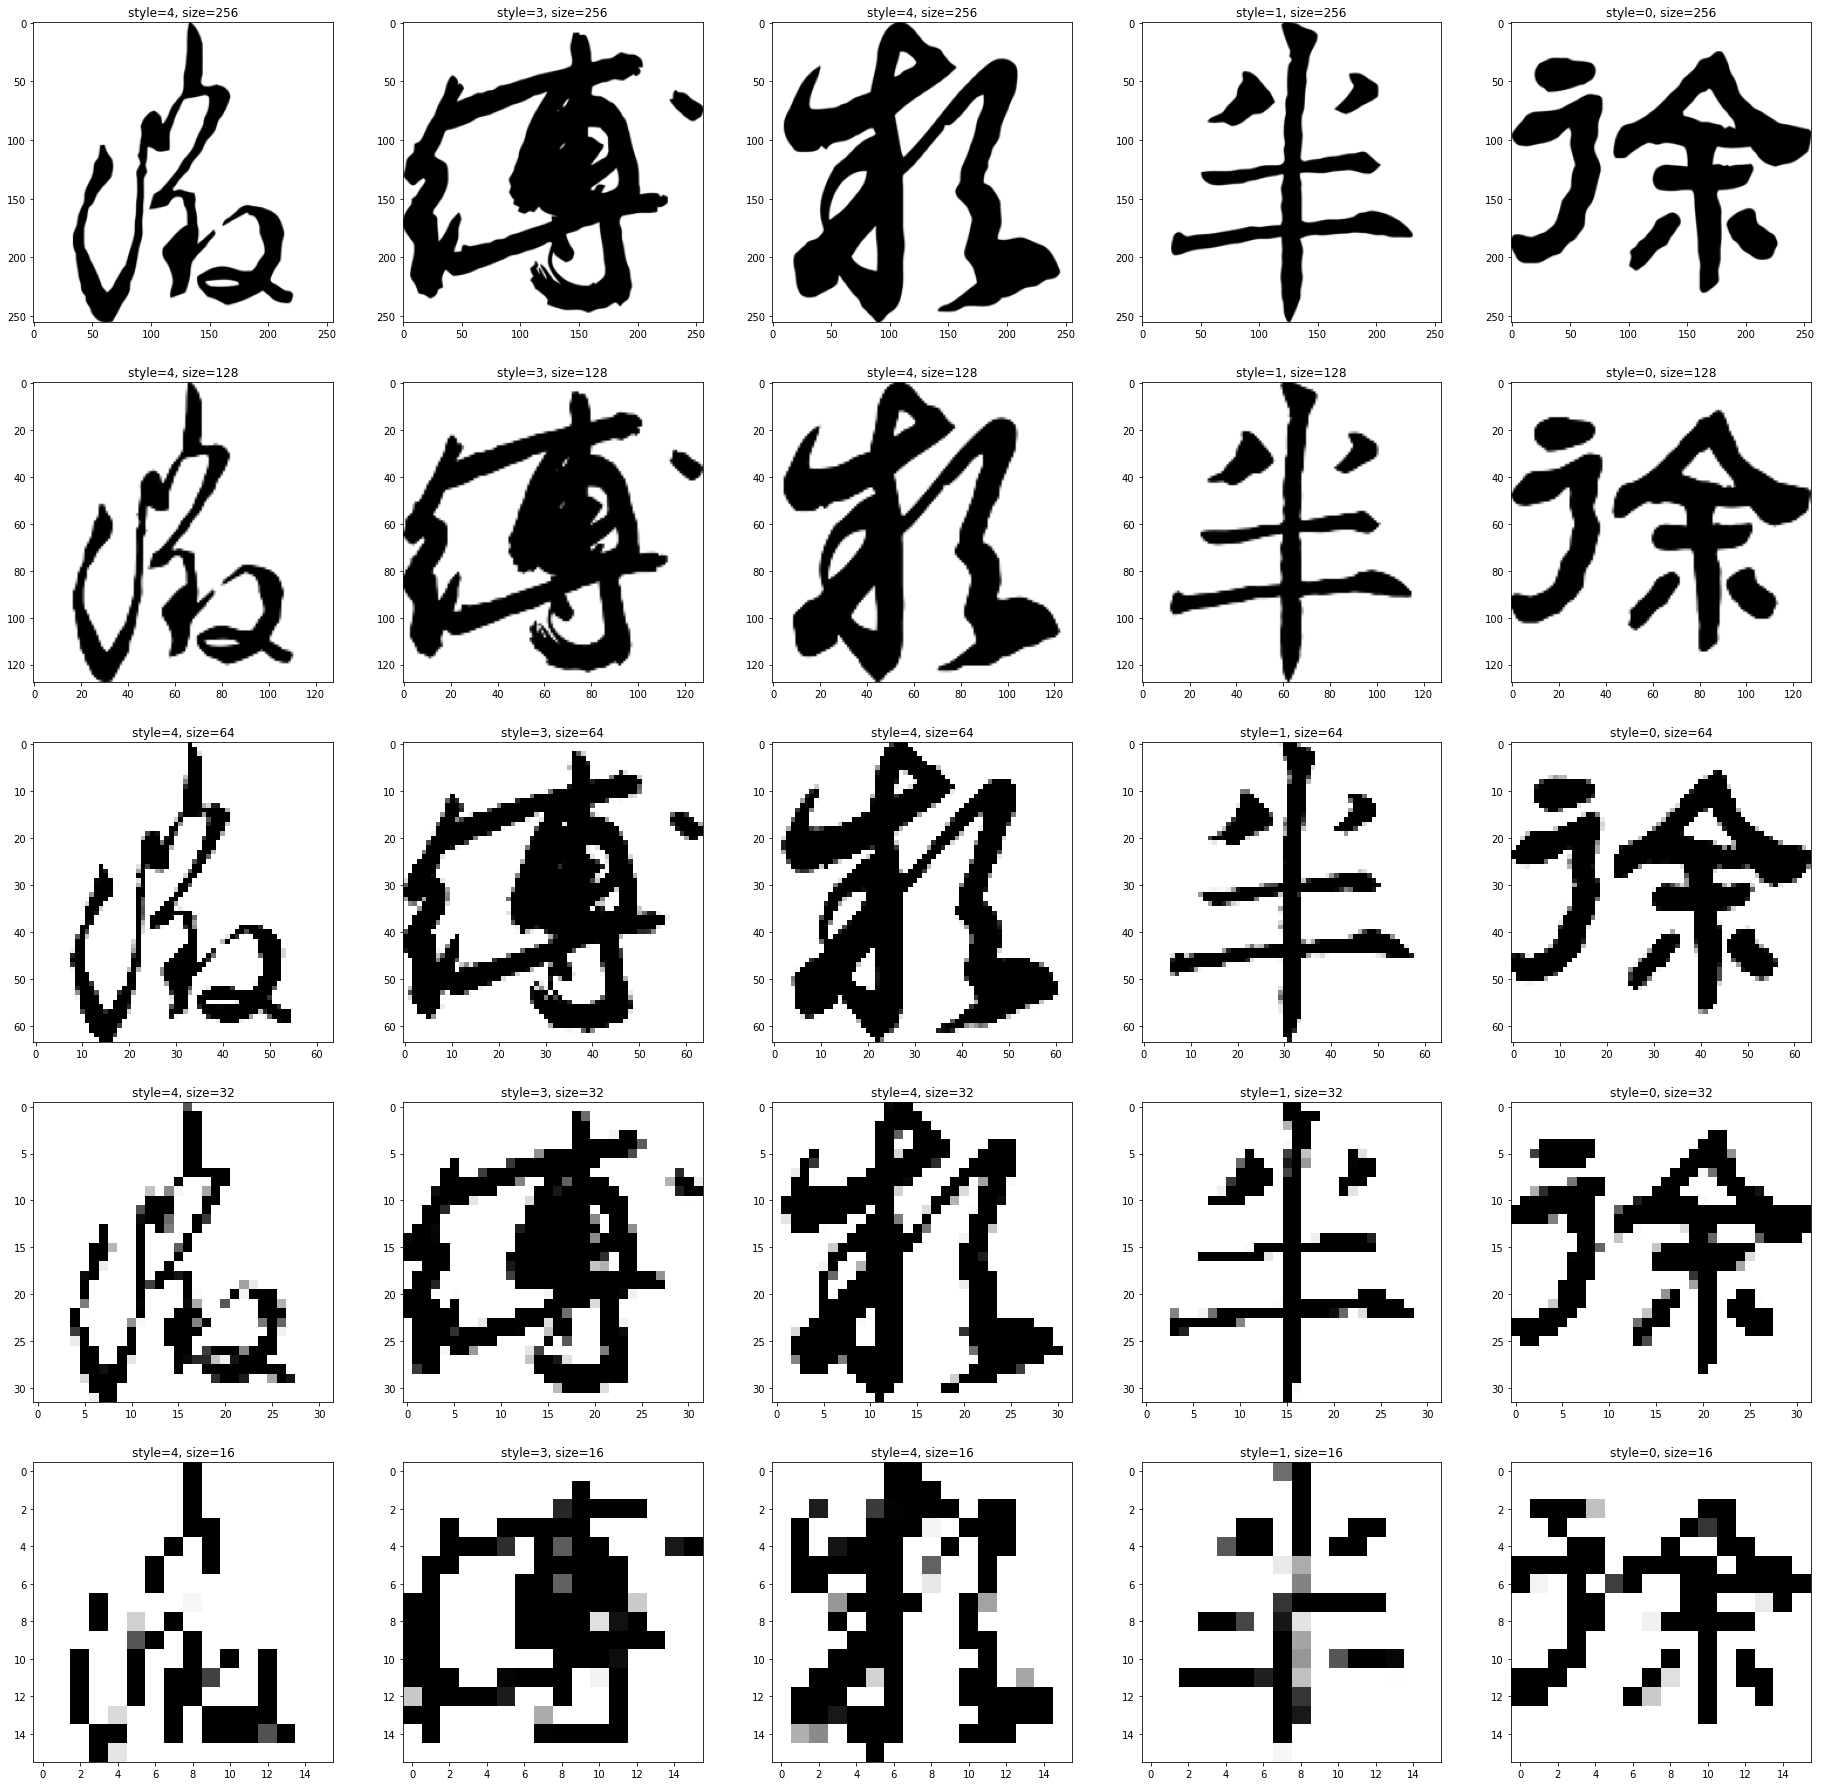

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(32, 32))
for s in range(5):
    view_image_size = math.ceil(256 / (2 ** s))
    (X, Y) = next(custom__batch_generator(dataframe, 5, view_image_size))
    for i in range(5):
        sb = plt.subplot(5,5,s * 5 + i + 1)
        sb.set_title("style=" + str(Y[i]) + ", size=" + str(view_image_size))
        plt.imshow(X[i], cmap=plt.cm.binary)
plt.show()

In [11]:
image_size = 64

optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)

model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu', padding="same", input_shape=(image_size, image_size, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (5, 5), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512))
model.add(layers.Dropout(rate = 0.4))
model.add(layers.Dense(512))
model.add(layers.Dropout(rate = 0.4))
model.add(layers.Dense(5))
model.add(layers.Activation('softmax'))
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [23]:
from tensorflow.keras.preprocessing import image as krs_image

def dataset_generator(dataframe, image_size, grayscale):
    # Create the arguments for image preprocessing
    data_gen_args = dict()

    # Create an empty data generator
    datagen = krs_image.ImageDataGenerator()
    length = len(dataframe)

    
    for i in range(length):
        try:
            # Read image from list and convert to array
            image_path = "./hanzi/" + dataframe["image"][i]
            image = krs_image.load_img(image_path, grayscale=True, target_size=(image_size, image_size))
            image = datagen.apply_transform(image, data_gen_args)
            image = krs_image.img_to_array(image)

            # Read data from csv using the name of current image
            csv_row = dataframe.loc[i, dataframe.columns != 'image']
            label = csv_row['style']
            #csv_features = csv_row.drop(labels='style')
            
            X = 1 - (image / 255)
            Y = styles.index(label)
            yield (X, Y)

        except Exception as err:
            # print(err)
            pass

def dataset_from_dataframe(dataframe, batch_size = 128, image_size = 64, grayscale = True):
    length = len(dataframe)
    channels = 1
    if not grayscale:
        channels = 3
    
    dataset = tf.data.Dataset.from_generator(
        lambda: dataset_generator(dataframe_train, image_size, grayscale),
        output_types = (tf.float32, tf.int64),
        output_shapes = ([image_size, image_size, channels], ())
    )
    steps = math.ceil(len(dataframe) / batch_size)
    return dataset.repeat().batch(batch_size), steps

train_dataset, train_steps = dataset_from_dataframe(dataframe_train)
validation_dataset, validation_steps = dataset_from_dataframe(dataframe_train)
test_dataset, test_steps = dataset_from_dataframe(dataframe_test)


In [20]:
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    train_dataset,
    steps_per_epoch = train_steps,
    validation_data = validation_dataset,
    validation_steps = validation_steps,
    epochs = 1,
    callbacks=[tensorboard_callback]
)

1094/1094 [==============================] - ETA: 0s - loss: 0.1686 - accuracy: 0.9333'顾蔼吉' is not in list
'毛泽东' is not in list
'王巩' is not in list
'张雨' is not in list
'智永' is not in list
'高元裕碑' is not in list
'王献之' is not in list
'王献之' is not in list
'邓石如' is not in list
'明人' is not in list
'鲜于枢' is not in list
cannot identify image file <_io.BytesIO object at 0x178f0d890>
'赵孟頫' is not in list
'水岛修三' is not in list
'王慈' is not in list
'董其昌' is not in list
'邓石如' is not in list
'马王堆帛书' is not in list
'敬世江' is not in list
'赵孟頫' is not in list
'毛泽东' is not in list
'敬世江' is not in list
'怀素' is not in list
'吴昌硕' is not in list
'敬世江' is not in list
'苏轼' is not in list
'张瑞图' is not in list
'杨沂孙' is not in list
'欧阳通' is not in list
1094/1094 [==============================] - 1938s 2s/step - loss: 0.1686 - accuracy: 0.9333 - val_loss: 0.1797 - val_accuracy: 0.9294


In [24]:
model.evaluate(test_dataset, steps = test_steps)

131/131 [==============================] - 59s 453ms/step - loss: 0.1761 - accuracy: 0.9281


[0.17613181471824646, 0.9280772805213928]